# Построение и интегрирование уравнений движения механической системы с двумя степенями свободы, используя уравнения Лагранжа II-го рода

Пример построения и численного интегрирования уравнений движения механической системы с двумя степенями свободы. 

[Юдинцев В. В.](https://classmech.ru), [Кафедра теоретической механики](http://tm.ssau.ru), [Самарский университет](https://ssau.ru).

In [74]:
# Символные математические преобразоания
import sympy as sp

# Для конструирования функций быстрых подстановок чисел в аналитические выражения 
from sympy.utilities.lambdify import lambdify

# Для печати красивых формул
sp.init_printing()

# Массивы, матрицы
import numpy as np

# Для численного интегрирования дифференциальных уранвений
from scipy.integrate import solve_ivp

# Для графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab

# Настройка стиля графиков
pylab.rcParams.update({'legend.fontsize': 14, 
                       'figure.figsize': (12, 8), 
                       'axes.labelsize': 14,
                       'axes.titlesize':14, 
                       'xtick.labelsize':14,
                       'ytick.labelsize':14,
                       'axes.grid' : True,
                       'grid.linestyle' : ':'})

Механическая система состоит из двух тел: однородной пластины и шарика - материальной точки. Полукруглая однородная пластина массой $m_1$ шарнирно закреплена и может вращаться в вертикальной плоскости вокруг точки О (точка О находится в середине диаметра полукруглой пластины). Внутри пластины в канале АВ движется тяжёлый шарик массой $m_2$. Шарик соединён с пластиной пружиной с известной жёсткостью $c$ и свободной длиной $l_0$. 

Таким образом, известны следующие параметры:

- $R$ - радиус пластины; 
- $m_1$ - масса пластины; 
- $m_2$ - масса шарика; 
- $a$ - расстояние от точки О до канала АВ;
- $c$ - жесткость пружины АМ;
- $l_0$ - свободная длина пружины;
- $y_с = OC_1$ - расстояние от точки О до центра масс пластины.

Схема механической системы приведена на следующем рисунке. 

![Механизм](https://github.com/Kidinnu/Kidinnu.github.io/raw/master/assets/img/blog/course_work_mech.png)

## Параметры и обобщённые координат

In [75]:
# Объявляем символьные параметры, которые будут использоваться при построении уравнений движения  
l0, c, R, a, b, m1, m2, yc, g, J1, t  = sp.symbols('l_0 c R a b m_1 m_2 y_c g J1 t')

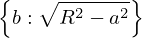

In [76]:
# Дополнительно введем словарь замен для тех символов, которые можно выразить через другие. 
# Выражать зависимые символы через независимые мы не будем, чтобы не условжнять вид уравнений 
# Например, расстояние b выражается через a и R:
rules = {b: sp.sqrt(R**2-a**2)}
rules

In [77]:
# Функции - координата шарика и угол поворота пластины (функции времени)
x      = sp.Function('x')
phi    = sp.Function('phi')

# Вектор обобщенных координат
q   = [ x(t), phi(t) ]

# скоростей (производная каждого элемента из q)
dq  = [ sp.diff(var,t) for var in q  ]

# и ускорений
d2q = [ sp.diff(var,t) for var in dq ]

## Кинематические соотношения

Для упрощения процедуры построения уравнений движения при помощи sympy определим матрицу поворота:

$$
    \boldsymbol A_z = \begin{bmatrix} \cos \varphi & -\sin \varphi \\ \sin \varphi & \cos \varphi \end{bmatrix},
$$

или матрицу преобразования координат между неподвижной системой координат $Ox_0y_0$ и подвижной системой координат, связанной с пластиной, $Ox'y'$.

Например, в системе координат, связанной с пластиной, координатный столбец радиус-вектора точки А относительно оси вращения записывается следующим образом:

$$
    \boldsymbol \rho_A' = \begin{bmatrix} -b \\ -a \end{bmatrix}
$$

Другими словами, точка А по отношению к точке О смещена в отрицательном направлении оси x' на величину $a$ и в отрицательном направлении оси y' на величину $b$. 

Координаты точки А в неподвижной системе $Ox_0y_0$:

$$
    \boldsymbol \rho_A = \begin{bmatrix} a \sin \varphi - b \cos \varphi \\ -a \cos \varphi - b \sin \varphi \end{bmatrix}
$$

Последнее выражение можно переписать, используя матрицу поворота $\boldsymbol A_z$:

$$
    \boldsymbol \rho_A = \begin{bmatrix} \cos \varphi & -\sin \varphi \\ \sin \varphi & \cos \varphi \end{bmatrix} \begin{bmatrix} -b \\ -a \end{bmatrix} = \boldsymbol A_z \boldsymbol \rho_A'
$$

Используя матрицу $\boldsymbol A_z$, можно записать координатый столбец шарика в неподвижной системе координат, зная координатный столбец его радиус-вектора в подвижной системе $Ox'y'$. Положение шарика относительно точки О определяется координатным столбцом вектора $\boldsymbol \rho_2'$, который представляет собой сумму двух векторов, имеющих простой вид:

$$
    \boldsymbol \rho_2' = \begin{bmatrix} -b \\ -a \end{bmatrix} + \begin{bmatrix} x(t) \\ 0 \end{bmatrix} = \rho_A' + \begin{bmatrix} x(t) \\ 0 \end{bmatrix}
$$

Координатный столбец шарика $\boldsymbol r_2$ в неподвижной системе $Ox_0y_0$ определим, умножив его на матрицу поворота: 
 
$$
    \boldsymbol r_2 = A_z \rho_2'
$$

Не будем вручную раскрывать это выражение, хотя оно и несложное, доверив эту работу библиотеке sympy. Зная радиус-вектор шарика в неподвижной системе координат, можно найти его скорость

$$
    \boldsymbol V_2 = \frac{d \boldsymbol r_2}{dt},
$$

а выражение для скорости шарика будет необходимо при формировании выражения для кинетической энергии шарика $T_2$ и механической системы в целом $T$, чтобы построить уравнения Лагранжа:

$$
    T_2 = \frac{m_2 |V_2|^2}{2}
$$

Дифференцирование координатного столбца радиус-вектора $\boldsymbol r_2$ тоже доверим библиотеке sympy.

In [78]:
# Символьная матрица поворота или матрица преобразования координат
Az = sp.Matrix([ [sp.cos(phi(t)), -sp.sin(phi(t))],
                 [sp.sin(phi(t)),  sp.cos(phi(t))] ])

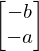

In [79]:
# Координатный столбец точки А в подвижной системе координат Ox'y'
rhoA = sp.Matrix([ [ -b ], 
                   [ -a ] ])
rhoA

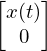

In [80]:
# Координатный столбец шарика относительно точки А в подвижной системе координат Ox'y'
# или координатный столбец радиус-вектора, проведённого из точки А в точку М
rho2 = sp.Matrix([ [ x(t) ], 
                   [ 0 ] ])

rho2

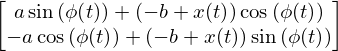

In [81]:
# Координатный столбец радиус-вектора шарика относительно точки О в неподвижной системе координат
r2 = Az*(rho2 + rhoA)
r2

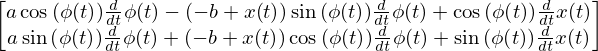

In [82]:
# Координатный столбец вектора скорости шарика относительно неподвижной системы координат
v2 = sp.diff(r2, t)
v2

## Момент инерции и положение центра масс пластины

### Момент инерции пластины относительно оси вращения О

Момент инерции пластины относительно оси вращения $O$:

$$
J_1 = \int r^2 \mu ds  = \int_0^R \int_0^{\pi} r^2 \mu r d \gamma dr = \mu \int_0^R \int_0^{\pi} r^3 d \gamma dr 
$$

где $\mu$ - масса единицы площади пластины. Для полукруглой пластины массой $m_2$ эта величина определяется отношением массы к площади половины круга:

$$
\mu = \frac{2 m_1}{\pi R^2}
$$

Интеграл $J_0$ легко найти "вручную":

$$
    J_1 = \mu \int_0^R \int_0^{\pi} r^3 d \gamma dr = \frac{2 m_1}{\pi R^2} \pi \frac{1}{4} R^4 = \frac{m_1 R^2}{2}
$$

но можно воспользоваться возможностями sympy

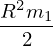

In [83]:
r, gamma = sp.symbols('r, gamma')
(2*m1/(sp.pi*R**2))*sp.integrate(sp.integrate(r**3, (r,0,R)), (gamma,0,sp.pi))

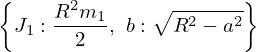

In [84]:
# Запомним результат в словаре замен
rules[J1] = (2*m1/(sp.pi*R**2))*sp.integrate(sp.integrate(r**3, (r,0,R)), (gamma,0,sp.pi))
rules

### Положение центра масс пластины

Положение центра масс пластины:

$$
    y_c = - \frac{1}{m_1} \int_0^R \int_0^{\pi} r \sin \gamma \mu r d \gamma dr
$$

![Механизм](https://raw.githubusercontent.com/Kidinnu/Kidinnu.github.io/master/assets/img/blog/course_work_inertia.png)

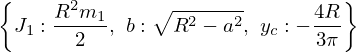

In [85]:
rules[yc] = -(2/(sp.pi*R**2))*sp.integrate(sp.integrate(r**2*sp.sin(gamma), (r,0,R)), (gamma,0,sp.pi))
rules

## Кинетическая энергия

### Кинетическая энергия шарика

$$
    T_2 = \frac{m_2 V_2^2}{2}
$$

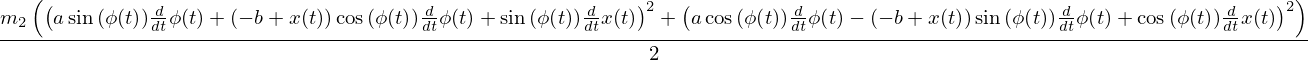

In [86]:
# v2.transpose()*v2 -- скалярное произведение скорости на саму себя
# результат - квадрат абсолютной скорости скорости шарика
T2 = m2*(v2.transpose()*v2)[0]/2
T2

### Кинетическая пластины

$$
    T_1 = \frac{J_1 \dot{\varphi}^2}{2}
$$

In [87]:
T1 = J1*sp.diff(phi(t),t)**2/2

### Кинетическая энергия системы

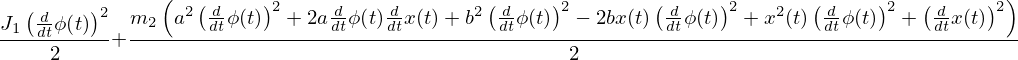

In [88]:
T = (T1 + T2).simplify()
T

## Потенциальная энергия

Потенциальная энергия пластины определяется высотой её центра масс над условно нулевым уровнем потенциальной энергии. 
Пусть плоскость нулевого уровня энергии проходит через ось вращения пластины.

$$
    \Pi_1 = m_1 g y_c \cos \varphi
$$

In [89]:
P1 = m1*g*yc*sp.cos(phi(t))

Потенциальная энергия шарика:

$$
    \Pi_2 = y_2 m_2 g
$$

In [90]:
P2 = r2[1]*m2*g 

Потенциальная энергия пружины

$$
    \Pi_s  = \frac{c (x-l_0)^2}{2}
$$

In [91]:
PS = c*(x(t)-l0)*(x(t)-l0)/2

Потенциальная энергия системы:

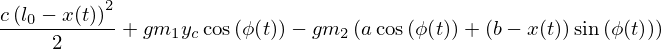

In [92]:
P = P1 + P2 + PS
P.simplify()

### Функция Лагранжа

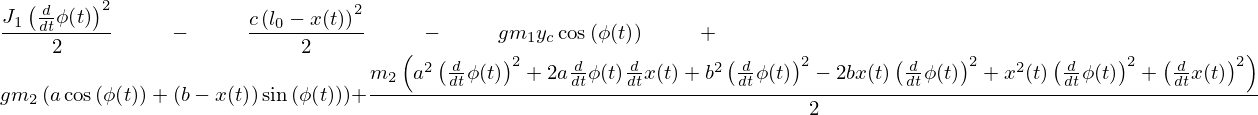

In [93]:
L = T - P
sp.simplify(L)

In [94]:
# Функция построяния уранения Лагранжа по заданной функции Лагранжа L и обощенной коодинате q
Lagrange_equation = lambda L, q : sp.diff(sp.diff(L,sp.diff(q)),t) - sp.diff(L,q)

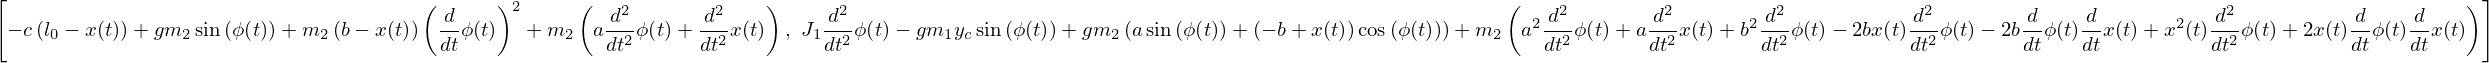

In [95]:
# Уравнения движения (без правой части = 0)
equations = [ sp.simplify(Lagrange_equation(L, q)) for q in (x(t), phi(t)) ]
equations

Разрешим уравнения относительно вторых производных

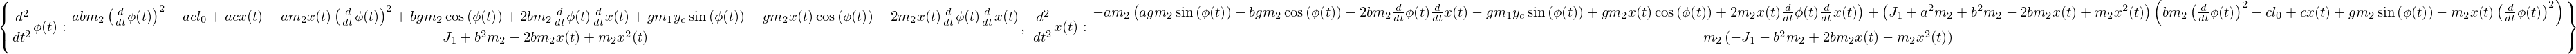

In [96]:
сauchy_equations = sp.solve(equations, d2q)
сauchy_equations

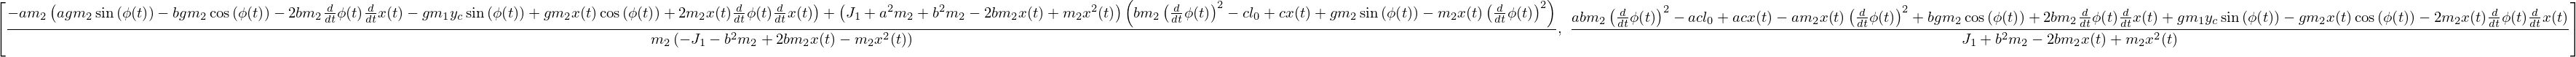

In [97]:
# Правая часть полученных уравнений (список выражений)
сauchy_equations_right_side = list(сauchy_equations.values())
сauchy_equations_right_side

## Численное интегрирование

In [98]:
# Список всех символов, встречающихся в уравнениях движения
symbol_list = [l0, c, R, a, b, m1, m2, yc, g, J1]
symbol_list

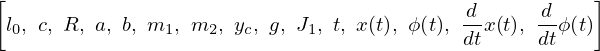

In [99]:
# Объединяем список символов со списком переменных состояния, включая время
# Этот набор будем передавать в 
params_and_state = [*symbol_list, t, *q, *dq]
params_and_state

In [100]:
#
# Словарь значений независимых параметров системы
#
params = {R: 1.0, a: 0.5, m1: 5, m2: 0.5, g: 9.807, c: 25, l0: 0.7}

In [101]:
# для каждого символа из symbol_list выполним подстановку из rules (символ может зависеть от других символов), 
# а затем подставим значения из params
params_list = [sym.subs(rules).subs(params).evalf() for sym in symbol_list]
# 
for el in zip(symbol_list, params_list):
    print(el[0], '= {:4.2f}'.format(el[1]))

l_0 = 0.70
c = 25.00
R = 1.00
a = 0.50
b = 0.87
m_1 = 5.00
m_2 = 0.50
y_c = -0.42
g = 9.81
J1 = 2.50


In [102]:
# Функция для вычисления правых частей дифференциальных уравнений
# При помощи функции lambdify определим функцию, 
# которая будет вычислять значения правых частей ДУ для заданных числовых параметров. 
# Первый аргумент функции lambdify -- список символов, 
# которые содержаться в вычисляемом выражении (сauchy_equations_right_side), 
# второй аргумент -- само символьное выражение.
f_right_side = lambdify(params_and_state, сauchy_equations_right_side)

#### Функция правых частей дифференциальных уравнений для интегратора solve_ivp

In [103]:
def dydt(t, y, params):
    # t - время
    # y[0] - x
    # y[1] - phi
    # y[2] - dx/dt
    # y[3] - dphi/dt    
    # функция возвращает
    # res[0] - dx/dt
    # res[1] - dphi/dt
    # res[2] - d2x/dt2
    # res[3] - d2phi/dt2
    # вычисляем вторые производные
    d2xd2phi = f_right_side( *[*params, t, *y] )    
    res = y.copy()
    # копируем скорости
    res[0:2] = y[2:4]
    # записываем ускорения    
    res[2:4] = d2xd2phi[0:2]
    return res

In [104]:
# Начальные условия
q0 = [0.8, 0.5, 0, 0];

# Интегрирование
solution = solve_ivp(lambda t, y: dydt(t, y, params_list), [0, 10.0], q0, 
                     rtol = 1e-6, method="LSODA", t_eval = np.linspace(0,10,500))

### Результаты 

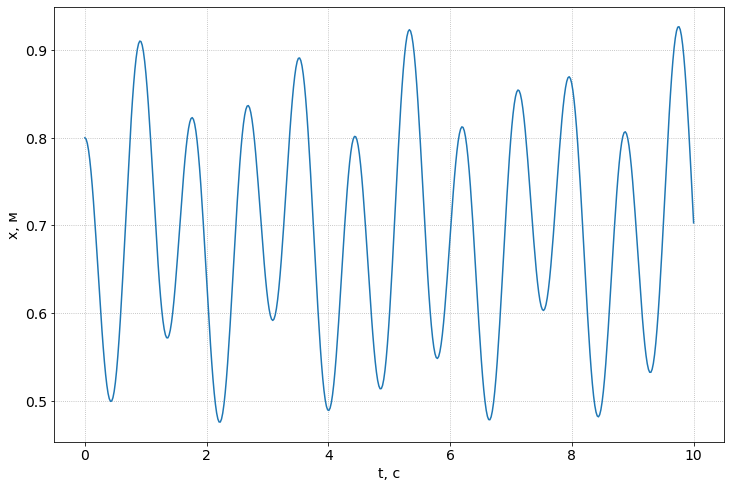

In [105]:
plt.plot(solution.t,solution.y[0]);
plt.xlabel('t, c');
plt.ylabel('x, м');

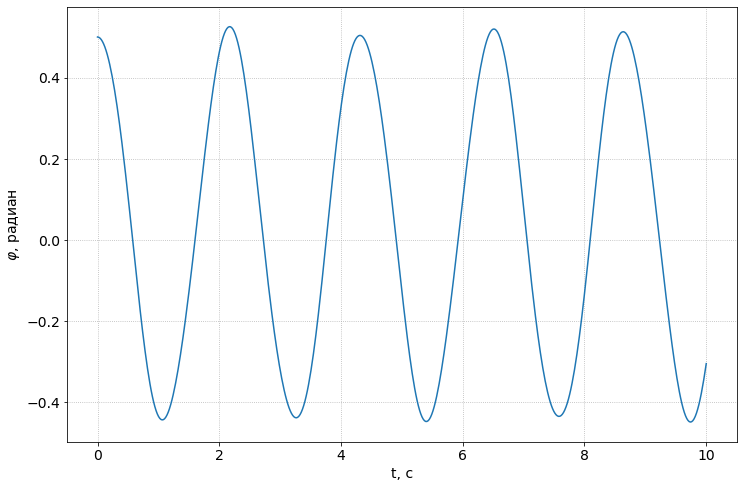

In [106]:
plt.plot(solution.t,solution.y[1]);
plt.xlabel('t, c');
plt.ylabel('$\\varphi$, радиан');

In [107]:
# Кинетическая, потенциальная и полная энергии системы
Energy = [T, P, T + P]
f_Energy = lambdify(params_and_state, Energy)

In [108]:
n_Energy = [ f_Energy(*[*params_list, state[0], *(state[1])]) for state in zip(solution.t, solution.y.transpose()) ] 

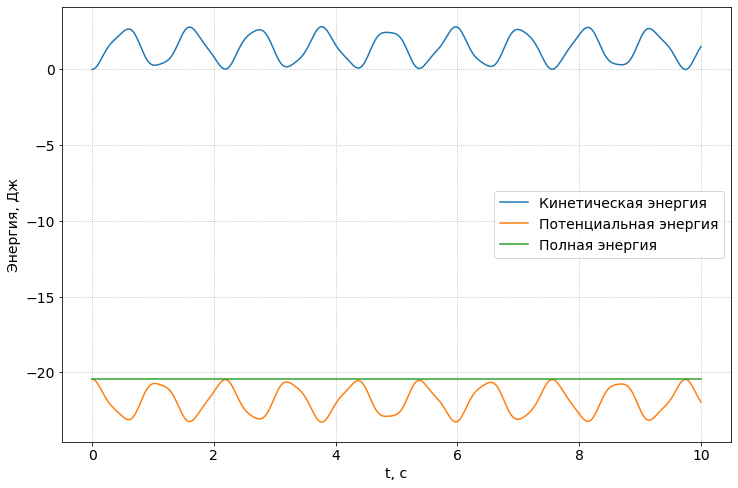

In [109]:
plt.plot(solution.t,n_Energy);
plt.legend(['Кинетическая энергия','Потенциальная энергия','Полная энергия'])
plt.xlabel('t, c');
plt.ylabel('Энергия, Дж');

## Анимация

In [110]:
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
from matplotlib.animation import FuncAnimation

In [111]:
# Функция для вычисления положения шарика по заданному символьному выражению (второй аргумент функции) и
# и фактическим значениям параметров системы и ее состоянию
n_r2 = lambdify(params_and_state, r2)

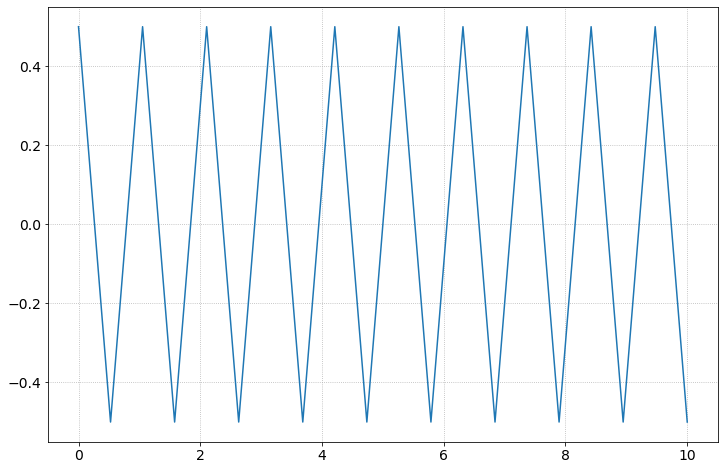

In [112]:
# Функция создает набор координат x,y для построения зигзагообразной линии, которая изображает пружину 
def get_spring_line(length, coils, diameter):
    x = np.linspace(0,length,coils*2)
    y = [ diameter*0.5*(-1)**i for i in range(len(x))]
    return np.array([x,y])

xy = get_spring_line(10, 10, 1)
plt.plot(xy[0],xy[1]);

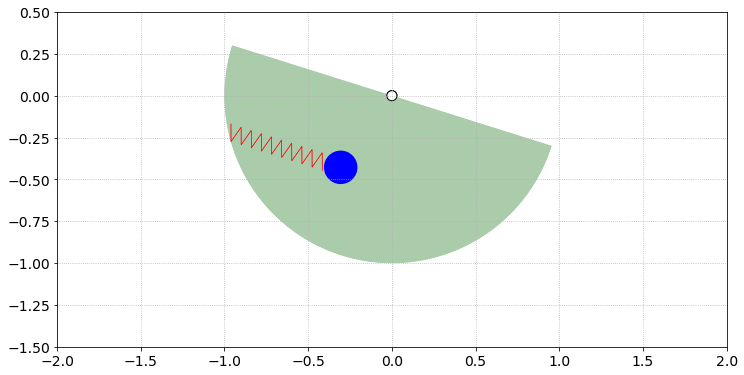

In [113]:
# матрица поворота 
nAz = lambda x: np.matrix([ [np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)] ])

# создаем рисунок
fig, ax = plt.subplots();
plt.xlim(-2,2)
plt.ylim(-1.5,0.5)
ax.set_aspect(1)

# полукруг (пластина) с центром в начале координат
body1 = Wedge([0,0], 1.0, -180+np.degrees(q0[1]), np.degrees(q0[1]), fc='#AACCAA')
# шарик
body2 = Wedge([0,0], 0.1, 0, 360, fc = 'b')
# пружина
spring_xy = get_spring_line(1, 10, 0.1)
spring    = mlines.Line2D(spring_xy[0], spring_xy[1], lw = 0.5, color = 'r')   

def init():    
    # Пластина
    ax.add_patch(body1)    
    # Ось вращения
    ax.add_patch(Wedge([0,0], 0.03, 0, 360, ec = 'black', fc = 'white'))
    # Шарик
    ax.add_patch(body2)    
    # Пружина
    ax.add_line(spring)    
    return spring, body1, body2, 
    
def get_frame(i):        
    phi = solution.y[1, i] 
    x   = solution.y[0, i] 
    t   = solution.t[i]
    
    # положение шарика относительно неподвижной системы координат
    r2 = n_r2(*[*params_list, t , x, phi, 0, 0]).astype(np.float).flatten()
    
    # положение точки А относительно неподвижной системы координат    
    rA = nAz(phi)*(rhoA.subs(rules).subs(params).evalf())
    
    body1.set_theta1(-180 + np.degrees(phi))
    body1.set_theta2(np.degrees(phi))        
    body1.get_path()
    
    body2.set_center([r2[0], r2[1]])    
    body2.get_path()
    
    spring_xy = nAz(phi)*get_spring_line(x-0.1, 10, 0.1)
    
    spring.set_xdata(spring_xy[0] + rA[0])
    spring.set_ydata(spring_xy[1] + rA[1])
    
    return spring, body1, body2 
    
anim = FuncAnimation(fig, get_frame, init_func=init, frames = len(solution.t), interval=50, blit=True)

anim.save('animation.mp4')